In [1]:
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.data_transformer import *
from sklearn.model_selection import train_test_split
from helper.utils import *
import pandas as pd

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


In [3]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [4]:
X_train, y_train = input_converter(merged_data, train_data)
X_val, y_val = input_converter(merged_data, val_data)
X_test, y_test = input_converter(merged_data, test_data)

In [5]:
df = list_to_dataframe(merged_data)

In [6]:
words = get_unique_words(df)
tags = get_unique_tags(df)

In [7]:
num_words = len(words)
num_tags = len(tags)
max_len = 100
model = mlp_model(num_words, num_tags, max_len)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           1344500   
                                                                 
 dense (Dense)               (None, 100, 128)          6528      
                                                                 
 dense_1 (Dense)             (None, 100, 64)           8256      
                                                                 
 dense_2 (Dense)             (None, 100, 32)           2080      
                                                                 
 time_distributed (TimeDistr  (None, 100, 7)           231       
 ibuted)                                                         
                                                             

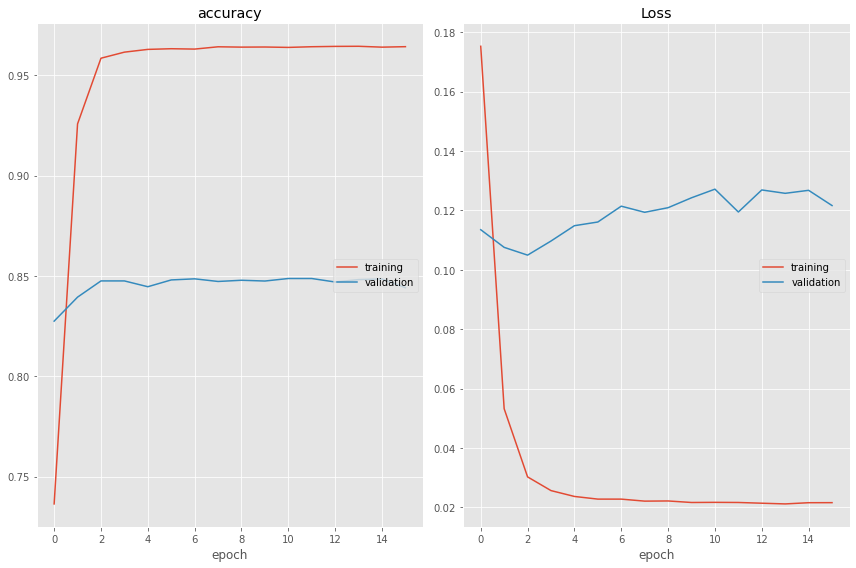

accuracy
	training         	 (min:    0.736, max:    0.964, cur:    0.964)
	validation       	 (min:    0.827, max:    0.849, cur:    0.844)
Loss
	training         	 (min:    0.021, max:    0.175, cur:    0.022)
	validation       	 (min:    0.105, max:    0.127, cur:    0.122)

Epoch 16: val_loss did not improve from 0.10495
56/56 [==============================] - 0s 3ms/step - loss: 0.1172 - accuracy: 0.8446
[0.11720562726259232, 0.8446407318115234]


In [8]:
root_path = 'model/'
model_name = 'mlp_model.h5'
num_epoch = 50
callbacks = get_callbacks(root_path, model_name)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose=1
)

print(model.evaluate(X_test, y_test))

In [15]:
from keras.models import load_model

mdl = load_model('model/mlp_model.h5')

In [16]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_test)):
    p = mdl.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = y_test[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_test[i], y_true, p[0]):
        if words[w-1] != "ENDPAD":
            # print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))
            w_pair.append(words[w-1])
            true_pair.append(tags[true])
            pred_pair.append(tags[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

In [17]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

              precision    recall  f1-score   support

          ID     0.7843    0.9831    0.8725     22309
          JV     0.9093    0.5914    0.7166      4914
          EN     0.9532    0.7468    0.8375      5020
   MIX-ID-EN     0.9173    0.8212    0.8666       973
   MIX-ID-JV     1.0000    0.8071    0.8933       280
   MIX-JV-EN     0.9149    0.6209    0.7398       277
           O     0.9788    0.7277    0.8348     10151

    accuracy                         0.8463     43924
   macro avg     0.9225    0.7569    0.8230     43924
weighted avg     0.8677    0.8463    0.8415     43924



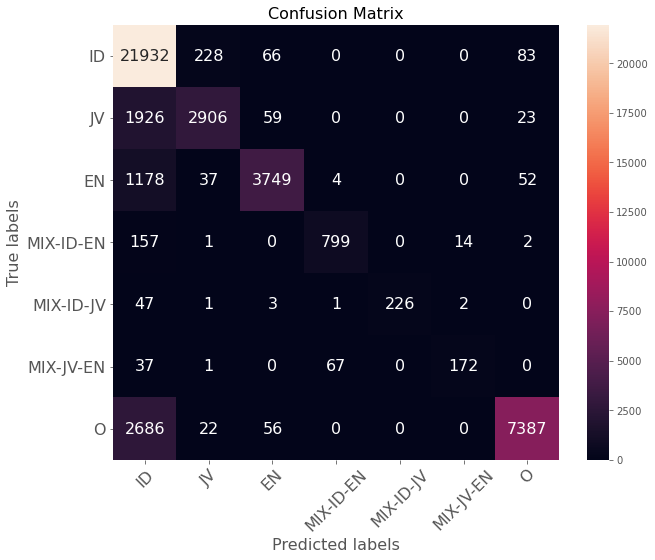

              precision    recall  f1-score   support

          ID     0.7843    0.9831    0.8725     22309
          JV     0.9093    0.5914    0.7166      4914
          EN     0.9532    0.7468    0.8375      5020
   MIX-ID-EN     0.9173    0.8212    0.8666       973
   MIX-ID-JV     1.0000    0.8071    0.8933       280
   MIX-JV-EN     0.9149    0.6209    0.7398       277
           O     0.9788    0.7277    0.8348     10151

    accuracy                         0.8463     43924
   macro avg     0.9225    0.7569    0.8230     43924
weighted avg     0.8677    0.8463    0.8415     43924



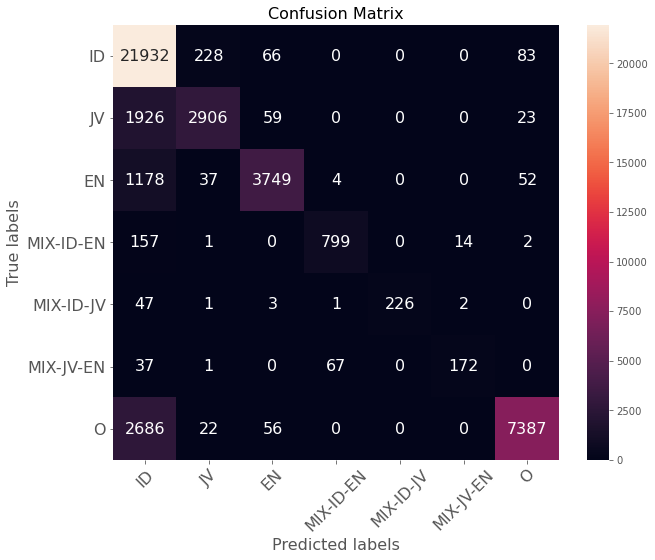

In [18]:
performance_report(true_flat, pred_flat)

In [19]:
i = np.random.randint(0, X_test.shape[0]) #659
p = mdl.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)

for w, true, pred in zip(X_test[i], y_true, p[0]):
    if words[w-1] != "ENDPAD":
        print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))

Word                          True      	 Pred

------------------------------------------------------------
oyi                           JV        	JV
rek                           JV        	JV
penjual                       ID        	ID
ayam                          ID        	ID
potong                        ID        	ID
di                            ID        	ID
pasar                         ID        	ID
itu                           ID        	ID
mau                           ID        	ID
apa                           ID        	ID
engga                         ID        	ID
ya                            ID        	ID
kalo                          ID        	ID
misal                         ID        	ID
kita                          ID        	ID
beline                        MIX-ID-JV 	MIX-ID-JV
fillet                        EN        	ID
?                             O         	O
spill                         EN        	EN
dipasar                       ID        	ID
mana 

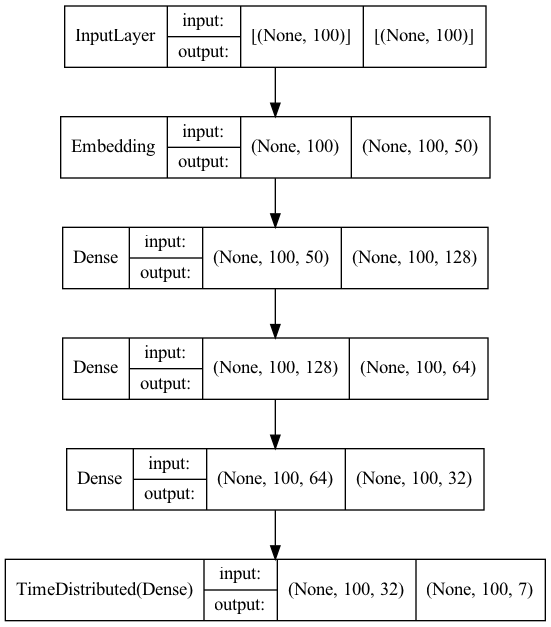

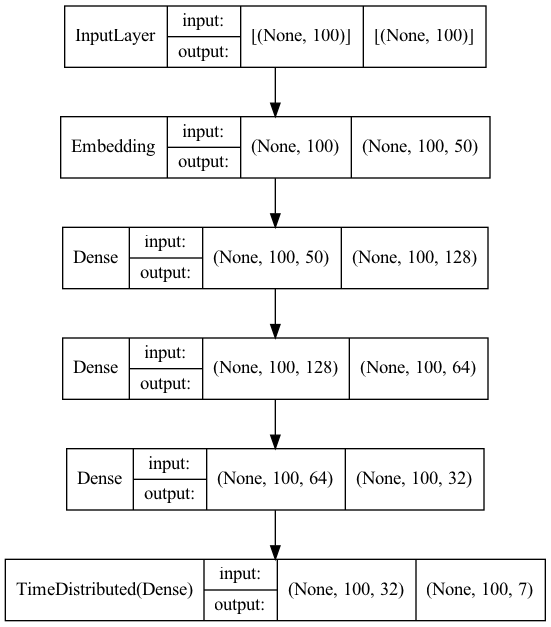

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot/tr_mlp.png', show_shapes=True, show_layer_names=False)